In [1]:
#LSTM1回目
#学校PC2024/1/12
#損失水頭、ろ過速どちらか０のとき洗浄時間
#水温U3

#参考
#ディープラーニングの本
#https://qiita.com/okadate/items/7b9620a5e64b4e906c42
#https://www.self-study-blog.com/dokugaku/python-pandas-csv-datetime-parse/
#見ただけ　https://qiita.com/ell/items/34f069651b551709d127
#少し　https://disassemble-channel.com/lstm-multivariate-time-series/
#層を増やすとき参考になりそう　https://supersoftware.jp/tech/20220907/17599/

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from scipy import interpolate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

df=pd.read_excel('myoken0.xlsx', index_col='日時')
df=df[['損失水頭_3号', 'ろ過速度h', '処理水濁度_1系', '処理水濁度_2系', 'PAC注入量34', '水温U3']]


#df=df.query('0<損失水頭_3号') #洗浄の時間を除去
df=df.interpolate(method='linear') #補間 #linear, time, index, values, nearest, zero, slinear, quadratic, cubic, barycentric, krogh, polynomial, spline, piecewise_polynomial, pchip #linear:値を等間隔に扱う、time:指定された長さの間隔を補間、index/values:インデックスの実際の数値、pad:既存の値を利用 #datetime型のindexの場合、indexが良い
df=df.rolling(7).mean() #移動平均 #Trueで中央に値を配置
df=df.dropna() #欠損値除去

x=df[['ろ過速度h', '処理水濁度_1系', '処理水濁度_2系', 'PAC注入量34', '水温U3']] #入力値
y=df[['損失水頭_3号']] #出力値
x=(x-x.min())/(x.max()-x.min()) #正規化

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, shuffle=False) #学習とテストデータに分割


#型を作成
x_tr=[]
y_tr=[]

#72時間_3日とした（８４時間でも高精度）
maxlen=72

for i in range(len(x_train)-maxlen):#全部の長さから分割の長さを引く
    x_tr.append(x_train.values[i:i+maxlen])

for i in range(len(y_train)-maxlen):
    y_tr.append(y_train.values[i+maxlen])

x_train=np.array(x_tr)
y_train=np.array(y_tr)

x_train=x_train.reshape(len(x_train), maxlen, 5)
y_train=y_train.reshape(len(y_train), 1)

x_te=[]
y_te=[]
for i in range(len(x_test)-maxlen):#全部の長さから分割の長さを引く
    x_te.append(x_test.values[i:i+maxlen])

for i in range(len(y_test)-maxlen):
    y_te.append(y_test.values[i+maxlen])

x_test=np.array(x_te)
y_test=np.array(y_te)

x_test=x_test.reshape(len(x_test), maxlen, 5)
y_test=y_test.reshape(len(y_test), 1)

def step_decay(epoch):
    a=0.001
    if epoch >=25:a=0.0005
    if epoch >=50:a=0.0001
    if epoch >=75:a=0.00005
    return a
lr_decay=LearningRateScheduler(step_decay)

#モデルの構築
lstm=Sequential()
lstm.add(LSTM(32, activation='tanh',
              recurrent_activation='sigmoid'))
lstm.add(Dense(1, activation='linear'))

#recurrent_activation:再帰計算時に使う活性化関数
#softmax, elu, selu, softplus, softsign, relu, tanh, sigmoid, nard_sigmoid, linear
#kernel_initializer:レイヤーの重み初期化方法
#initializer, zeros, ones, constant, RandomNormal, RandomUniform, TruncatedNormal, VarianceScaling, Orthogonal, Identity, glorot_normal, glorot_uniform, ge_normal, lecun_normal, he_uniform, lecun_uniform

#モデルの学習
optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999) #beta浮動小数点数 0<beta<1 一般的に１に近い値
#optimaizer最適化手法(lbfgs, sgd, adam)
#learning_rate学習率（0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001）

lstm.compile(optimizer=optimizer,
             loss='mean_squared_error') #二乗平均誤差関数


#EarlyStopping過学習を防ぐための関数
es=EarlyStopping(monitor='loss',
                 patience=10,
                 verbose=1)
#patience 指定した回数val_lossの減少が止まると学習がストップする
#verbose 0:ログを出力しない、1:標準出力、2:エポックごとに１行のログを出力

#reduce_lr=ReduceLROnPlateau(monitor='loss', factor=0.2, mode='auto', patience=5, min_lr=0.001)
#monitor:, factor:学習率を下げる係数, patience:エポック数を増やしても改善が見られない場合学習率は低下する, verbose:メッセージ, mode:min/max/auto, min_delta, cooldown:, min_lr:学習率の下限
#https://keras.io/api/callbacks/reduce_lr_on_plateau/
hist=lstm.fit(x_train, y_train,
              epochs=100,
              batch_size=32,
              verbose=2,
              callbacks=[es, lr_decay]) #reduce_lrこれも使うなら上で定義する

Epoch 1/100
436/436 - 4s - loss: 0.0684 - lr: 0.0010 - 4s/epoch - 9ms/step
Epoch 2/100
436/436 - 3s - loss: 0.0311 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 3/100
436/436 - 3s - loss: 0.0254 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 4/100
436/436 - 3s - loss: 0.0236 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 5/100
436/436 - 3s - loss: 0.0214 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 6/100
436/436 - 3s - loss: 0.0192 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 7/100
436/436 - 3s - loss: 0.0168 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 8/100
436/436 - 3s - loss: 0.0166 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 9/100
436/436 - 3s - loss: 0.0152 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 10/100
436/436 - 3s - loss: 0.0142 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 11/100
436/436 - 3s - loss: 0.0136 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 12/100
436/436 - 3s - loss: 0.0133 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 13/100
436/436 - 3s - loss: 0.0127 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 14/100
436/436 

In [3]:
open('lstm_1.json', "w").write(lstm.to_json())
lstm.save_weights('lstm_1.h5')

In [2]:
#精度の評価
#https://di-acc2.com/programming/python/12253/#モデル学習-単回帰モデルを作成

y_train_pred=lstm.predict(x_train)
y_test_pred=lstm.predict(x_test)

print('RMSE 学習: %.2f, テスト: %.2f' %(
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)
    ))

print('R2 学習: %.2f, テスト: %.2f' %(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)
    ))

108/108 [==============================] - 0s 3ms/step
RMSE 学習: 0.05, テスト: 0.11
R2 学習: 0.99, テスト: 0.95


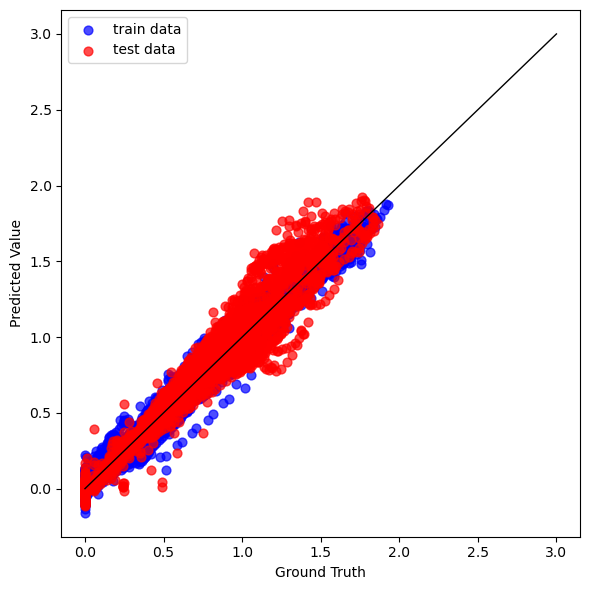

In [4]:
plt.figure(figsize=(6, 6))
plt.plot([0, 3], [0, 3], linewidth=1, c='black')
#予測値と実測値　学習データ
plt.scatter(y_train,
            y_train_pred,
            c='blue',
            marker='o',
            s=40,
            alpha=0.7,
            label='train data')

#予測値と実測値　テストデータ
plt.scatter(y_test,
            y_test_pred,
            c='red',
            marker='o',
            s=40,
            alpha=0.7,
            label='test data')

#グラフ書式
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Value')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

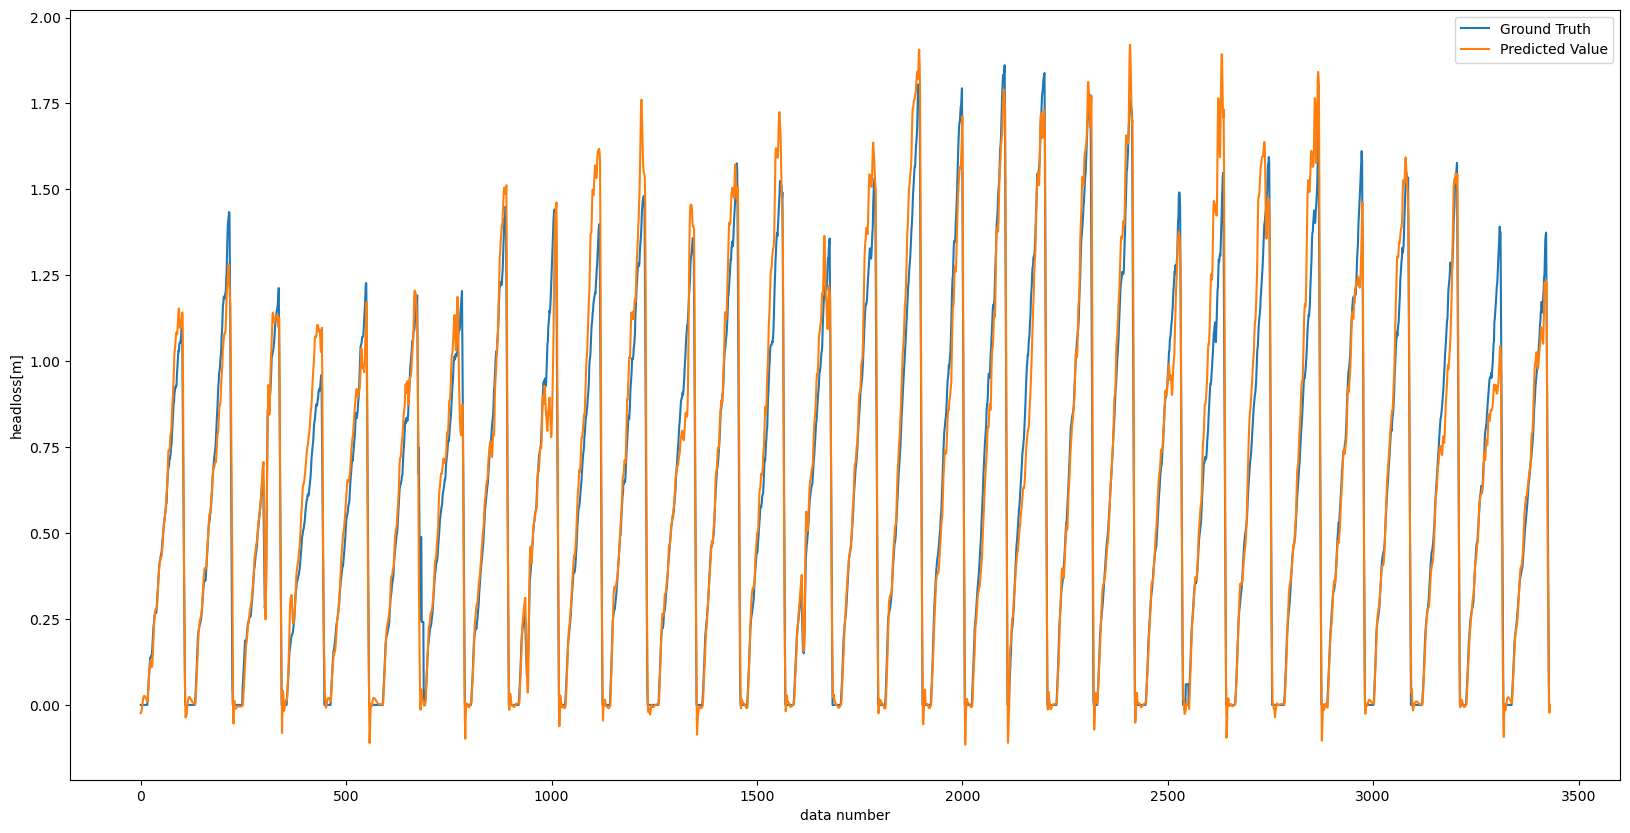

In [7]:
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.plot(y_test, label="Ground Truth")
plt.plot(y_test_pred, label="Predicted Value")
plt.legend()
plt.xlabel('data number')
plt.ylabel('headloss[m]')
plt.show()

In [16]:
prediction=pd.DataFrame(y_test_pred, columns=['y_test_pred']).to_csv('lstm_1_pred.csv', index=True)
true=pd.DataFrame(y_test, columns=['y_test']).to_csv('lstm_1_test.csv', index=True)